<a href="https://colab.research.google.com/github/rigonzal/ANN/blob/master/Approach2/Pregunta_1_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF-395 Redes Neuronales Artificiales II-2018

## Tarea 2 - Redes Convolucionales y sus aplicaciones


26/11/2018

* Rodrigo González Smith 201303026-2
* Ignacio Valenzuela Albornoz

## Introducción



Débido al tema del trabajo usaremos **Keras** para la creación de las redes y su posterior entrenamiento/validación. Como también las librerías comunes de trabajo de Python:

In [0]:
#Correr solo en Colab
!pip install -q keras

In [2]:
import numpy as np   
import os   
import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
from keras.models import model_from_json
import os
import h5py

%matplotlib inline

Using TensorFlow backend.


## 1. Convolutional Neural Networks (CNN) en CIFAR

Para esta primera parte del informe se trabajaran con los datos de CIFAR10, los cuales correspondes a imágenes las cuales tendremos que clasificar en sus cateogrías correspondientes. De esta manera usaremos CNN, las cuales son adecuadas y efectivas para este tipo de tareas.   

### 1.a) Exploración del Dataset

El data set cuenta con 60.000 imágenes con resolución 32x32, las cuales se clasifican en 10 categorías.  Las proporciones de los datos serán 40.000, 10.000 y 10.000 respectivamente para entrenamiento, validación y test.

In [3]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']  
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 31s 0us/step


Extraemos algunas imágenes para visualizar con sus respectivas etiquetas:

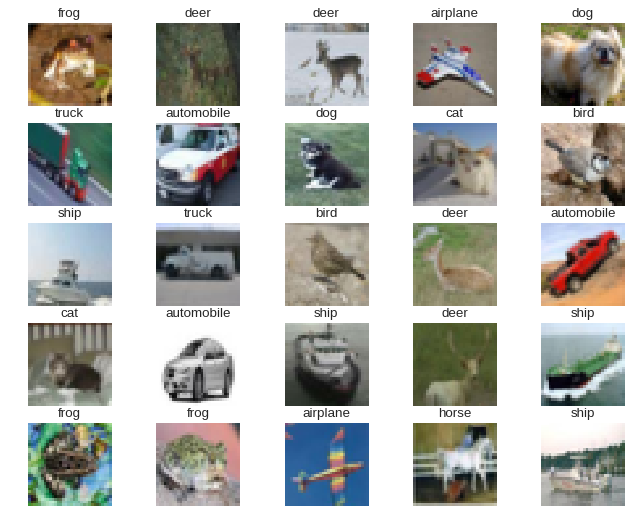

In [4]:
# Aumentamos el tamaño del plot
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

for i in range(25):  
  plt.subplot(5,5,i+1)
  plt.title(label_names[y_train[10*i][0]])
  plt.axis('off')
  _=plt.imshow(x_train[10*i])

La mala resolución se debe a los poco pixeles de la muestra, sin embargo para nuestros fines sera suficiente en el trabajo. Siguiente a esto separamos según como dijimos previamente los datos:

In [5]:
n_train = len(x_train)
x_val = x_train[int(0.8*n_train):n_train]
y_val = y_train[int(0.8*n_train):n_train]
x_train = x_train[:int(0.8*n_train)]
y_train = y_train[:int(0.8*n_train)]

print("Partición del dataset: ")
print("[Training]: " + str(len(x_train)))
print("[Validation]: " + str(len(x_val)))
print("[Test]: " + str(len(x_test)))

Partición del dataset: 
[Training]: 40000
[Validation]: 10000
[Test]: 10000


### 1.b) Preparación de dataset

Normalizamos los datos para que estén en el rango $x \in [0,1]$. En este caso, dado que son positivos al ser RGB. 

In [6]:
x_train_norm = x_train/255
x_val_norm = x_val/255
x_test_norm = x_test/255

num_classes = len(label_names)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("Dimensión de cada fila: " + str(x_train_norm[0].shape))

Dimensión de cada fila: (32, 32, 3)


En donde la tercera columna corresponde a la codificación RGB o *channels*.    Por lo cual se estará usando el orden de TensorFlow para el ordenamiento de las dimensiones de las imagenes.

### 1.c) Definición CNN

Se define la red neuronal convolucional inicial a usar para la clasificación.  Se muestra un esquema respecto a la estructura interior de la red, con las dimensiones y sus cambios a medida que se avanza en ella. Notamos que antes de entrar a la capa densa de 512 neurona, se debe hacer un*flatten* del output de la anterior, con tal de que sea un vector de pesos el Input.



In [0]:
model_1_c = Sequential()
model_1_c.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_1_c.add(Activation('relu'))
model_1_c.add(MaxPooling2D(pool_size=(2, 2)))
model_1_c.add(Conv2D(64, (3, 3), padding='same'))
model_1_c.add(Activation('relu'))
model_1_c.add(MaxPooling2D(pool_size=(2, 2)))
model_1_c.add(Flatten())
model_1_c.add(Dense(512))
model_1_c.add(Activation('relu'))
model_1_c.add(Dense(10))
model_1_c.add(Activation('softmax'))
model_1_c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

### 1.d) Entrenamiento CNN

Para entrenar se usara el algoritmo del gradiente estocástico, con un momentum de 0.9. Además la tasa de apredizaje será cambiada manualmente, y estará en el rango $\eta \in [{10^{-3},10^{-5}}] $.  Esta se reduce a la mitad cada 10 épocas, el entrenamiento inicial se hizo con 25.

In [44]:
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((epoch)/10))
    lrate = max(lrate,0.00001)
    return lrate
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
batch_size = 1000
epochs = 25
model_1_c.compile(loss="categorical_crossentropy" , optimizer=opt )
history_1_c = model_1_c.fit(x_train_norm, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val_norm,y_val), shuffle=True, callbacks=[lrate])

NameError: ignored

Con la red ya entrenada, se grafica la perdida de training contra la validación, para de esta manera tener una visión más general de la tendencia en el proceso de entrenamiento:

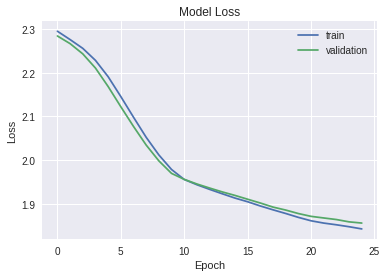

In [0]:
plt.plot(history_1_c.history['loss'])
plt.plot(history_1_c.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Notamos entonces que el error podría haber seguido disminuyendo si se entrenaban algunas épocas más, sin embargo el error en la validación ya estaba mostrando tendencias a separarse. Por lo cual puede que se empezara a "estancar" después de algunas épocas más.

### 1.e)  RMSProp

Ahora entrenaremos la red con RMSProp,  el cual reduce la tasa de aprendizaje o *learning rate* a medida que avanzan las épocas de entrenamiento,  adaptandolo según la acumulación de valores anteriores de los gradientes descendientes. Donde por defecto se usará $\gamma  = 0.9$, el cual controla el largo de la escala de los promedios moviles. La idea de usar estos promedios moviles, es que la división de la tasa de aprendizaje se haga por números similares, entre *batches* adyacentes. Calcularemos el error de training, validación y test:


In [41]:
#función necesaria para obtener también el error de test
def get_loss(model, data, epochs, batchs, opt, lrate=None):
  history_1_e = list()
  history_1_e_test = list()
  for i in range(epochs):
    print("Epoch " + str(i+1) +"/" + str(epochs))
    if lrate == None:
      history = model.fit(data[0], data[1],batch_size=batchs,epochs=1, validation_data=(data[2],data[3]), shuffle=True)
    else:
       history = model.fit(data[0], data[1],batch_size=batchs,epochs=1, validation_data=(data[2],data[3]), shuffle=True,callbacks=[lrate])
    history_1_e.append(history)
    history = model.evaluate(data[4],data[5])
    print(history)
    history_1_e_test.append(history)
  return history_1_e,history_1_e_test



#se define el modelo
model_1_e = Sequential()
model_1_e.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_1_e.add(Activation('relu'))
model_1_e.add(MaxPooling2D(pool_size=(2, 2)))
model_1_e.add(Conv2D(64, (3, 3), padding='same'))
model_1_e.add(Activation('relu'))
model_1_e.add(MaxPooling2D(pool_size=(2, 2)))
model_1_e.add(Flatten())
model_1_e.add(Dense(512))
model_1_e.add(Activation('relu'))
model_1_e.add(Dense(10))
model_1_e.add(Activation('softmax'))

#se agrega optimizador
opt = rmsprop(lr=0.001, decay=1e-6)
batch_size = 1000
epochs = 25
model_1_e.compile(loss="categorical_crossentropy" , optimizer=opt )

#se agrega a una lista todos los datos para evitar funciones engorrosas, lo cual servirá para futuras ejecuciones
data = [x_train_norm, y_train, x_val_norm, y_val, x_test_norm, y_test]


history_1_e, history_1_e_test= get_loss(model_1_e, data, epochs, batch_size, opt)

Epoch 1/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 119us/step
1.9164281715393066
Epoch 2/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 120us/step
1.9488582592010497
Epoch 3/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 120us/step
1.5868545585632323
Epoch 4/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 120us/step
1.5859142631530763
Epoch 5/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 119us/step
1.4737286506652831
Epoch 6/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 119us/step
1.5161849241256713
Epoch 7/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==========

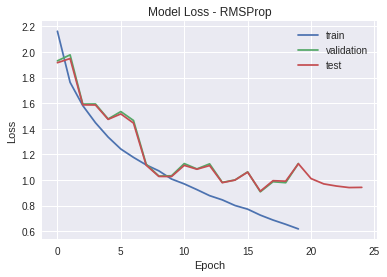

In [48]:
def triple_plot(loss_train, loss_val, loss_test,title):
  plt.plot(loss_train)
  plt.plot(loss_val)
  plt.plot(loss_test)
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  #plt.xlim(3,4)
  plt.legend(['train', 'validation','test'], loc='upper right')
  plt.show()

loss_train = list()
loss_val = list()
for i in range(epochs):
  loss_train.append(history_1_e[i].history['loss'])
  loss_val.append(history_1_e[i].history['val_loss'])
 
triple_plot(loss_train, loss_val, history_1_e_test,'Model Loss - RMSProp')



Un claro caso de Overfitting en el modelo al usar RMSProp,  sin embargo el valor al  que se empezó a llegar en la valdación y test es menor que haciendo una reducción manual del *learning rate*. Espor lo cual que repetiremos pero probando con una reducción de este problema usando Dropout, así la red no tenderá a crear conexiones demasiado complejas, al obligar a que use otros pesos.

In [0]:
model_1_e = Sequential()
model_1_e.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_1_e.add(Activation('relu'))
model_1_e.add(MaxPooling2D(pool_size=(2, 2)))
model_1_e.add(Conv2D(64, (3, 3), padding='same'))
model_1_e.add(Activation('relu'))
model_1_e.add(MaxPooling2D(pool_size=(2, 2)))
model_1_e.add(Flatten())
model_1_e.add(Dense(512))
model_1_e.add(Activation('relu'))
model_1_e.add(Dense(10))
model_1_e.add(Activation('softmax'))

opt = rmsprop(lr=0.001, decay=1e-6)
batch_size = 1000
epochs = 25
model_1_e.compile(loss="categorical_crossentropy" , optimizer=opt )

#se agrega a una lista todos los datos para evitar funciones engorrosas, lo cual servirá para futuras ejecuciones
data = [x_train_norm, y_train, x_val_norm, y_val, x_test_norm, y_test]


history_1_e, history_1_e_test= get_loss(model_1_e, data, epochs, batch_size, opt)

### 1.f) Variación tamaño filtros de convolución

Se modifica el tamaño de los filtros, posteriormente se debe analizar su error antes estos cambios. Lo anterior se realizará para una red *shallow*/poco profunda y una *deep*/profunda. Finalmente se compara los errores para comentar. Se seguirá usando RMSProp por los buenos y mejores resultados obtenidos en vez de usar gradiente estocastico como optimizador.

##### 1.f.1) Shallow network

In [45]:
models_1_f_shallow = list()
histories_1_f_shallow = list()
histories_1_f_shallow_test = list()
for i in range(3):

    """Shallow network"""
    nc = i+2 #convolutional filter size
    models_1_f_shallow.append(Sequential())
    models_1_f_shallow[i].add(Conv2D(64, (nc,nc), padding='same', input_shape=x_train.shape[1:]))
    models_1_f_shallow[i].add(Activation('relu'))
    models_1_f_shallow[i].add(MaxPooling2D(pool_size=(2, 2)))
    models_1_f_shallow[i].add(Flatten())
    models_1_f_shallow[i].add(Dense(512))
    models_1_f_shallow[i].add(Activation('relu'))
    models_1_f_shallow[i].add(Dense(10))
    models_1_f_shallow[i].add(Activation('softmax'))

    opt = rmsprop(lr=0.001, decay=1e-6)
    batch_size = 1000
    epochs = 20
    models_1_f_shallow[i].compile(loss="categorical_crossentropy" , optimizer=opt )

    history_1_f_shallow, history_1_f_shallow_test = get_loss(models_1_f_shallow[i], data, epochs, batch_size, opt,  lrate)
    histories_1_f_shallow.append(history_1_f_shallow)
    histories_1_f_shallow_test.append(history_1_f_shallow_test)

Epoch 1/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 120us/step
1.8111941707611083
Epoch 2/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 121us/step
1.5204954076766968
Epoch 3/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 127us/step
1.5102777576446533
Epoch 4/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 124us/step
1.3554804166793823
Epoch 5/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 124us/step
1.3397723236083985
Epoch 6/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 127us/step
1.3263792486190795
Epoch 7/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==========

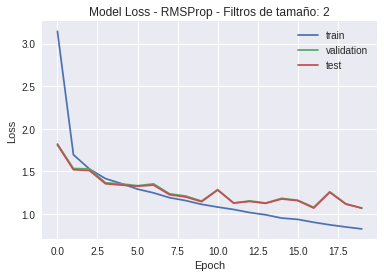

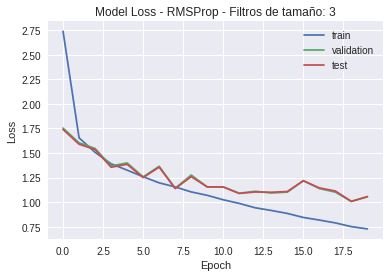

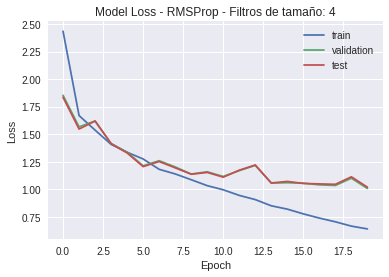

In [46]:
#ploteo de 3 modelos shallow con distintos filtros convolucionales
loss_train_1_f_shallow = list()
loss_val_1_f_shallow = list()
for i in range(3):
  loss_train = list()
  loss_val = list()
  for j in range(epochs):
    loss_train.append(histories_1_f_shallow[i][j].history['loss'])
    loss_val.append(histories_1_f_shallow[i][j].history['val_loss'])
  loss_train_1_f_shallow.append(loss_train)
  loss_val_1_f_shallow.append(loss_val)

  triple_plot(loss_train_1_f_shallow[i], loss_val_1_f_shallow[i], histories_1_f_shallow_test[i], "Model Loss - RMSProp - Filtros de tamaño: " +  str(i+2))

##### 1.f.2) Dense network

Para este caso usaremos una red densa con la arquitectura: $C \times P \times C \times P \times C \times P   \times F \times F$ y de esta manera entrenaremos para posteriormente comparar con la red *shallow* previamente usada en la clasificación.

In [37]:
models_1_f_dense = list()
histories_1_f_dense = list()
histories_1_f_dense_test = list()
for i in range(3):

    """dense network"""
    nc = i+2 #convolutional filter size
    models_1_f_dense.append(Sequential())
    models_1_f_dense[i].add(Conv2D(64, (nc,nc), padding='same', input_shape=x_train.shape[1:]))
    models_1_f_dense[i].add(Activation('relu'))
    models_1_f_dense[i].add(MaxPooling2D(pool_size=(2, 2)))
    models_1_f_dense[i].add(Conv2D(64, (nc,nc), padding='same'))
    models_1_f_dense[i].add(Activation('relu'))
    models_1_f_dense[i].add(MaxPooling2D(pool_size=(2, 2)))
    models_1_f_dense[i].add(Conv2D(64, (nc,nc), padding='same'))
    models_1_f_dense[i].add(Activation('relu'))
    models_1_f_dense[i].add(MaxPooling2D(pool_size=(2, 2)))
    models_1_f_dense[i].add(Flatten())
    models_1_f_dense[i].add(Dense(512))
    models_1_f_dense[i].add(Activation('relu'))
    models_1_f_dense[i].add(Dense(10))
    models_1_f_dense[i].add(Activation('softmax'))

    opt = rmsprop(lr=0.001, decay=1e-6)
    batch_size = 1000
    epochs = 20
    models_1_f_dense[i].compile(loss="categorical_crossentropy" , optimizer=opt )

    history_1_f_dense, history_1_f_dense_test = get_loss(models_1_f_dense[i], data, epochs, batch_size, opt)
    histories_1_f_dense.append(history_1_f_dense)
    histories_1_f_dense_test.append(history_1_f_dense_test)

Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 125us/step
1.7521411430358886
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 120us/step
1.5955874097824096
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 121us/step
1.683322804069519
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 119us/step
1.5524966737747192
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 121us/step
1.4064021202087402
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 121us/step
1.4787369766235352
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 121us/step
1.3616690267562865
Train on 40000 sample

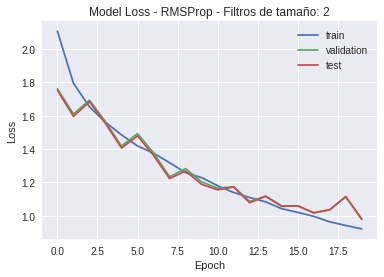

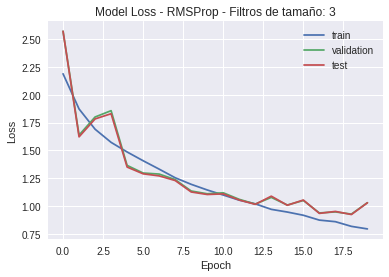

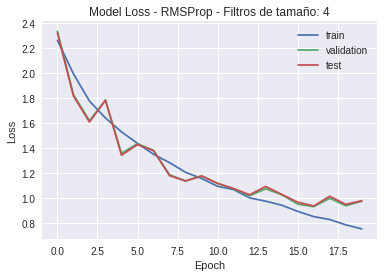

In [38]:
#ploteo de 3 modelos shallow con distintos filtros convolucionales
loss_train_1_f_dense = list()
loss_val_1_f_dense = list()
for i in range(3):
  loss_train = list()
  loss_val = list()
  for j in range(epochs):
    loss_train.append(histories_1_f_dense[i][j].history['loss'])
    loss_val.append(histories_1_f_dense[i][j].history['val_loss'])
  loss_train_1_f_dense.append(loss_train)
  loss_val_1_f_dense.append(loss_val)

  triple_plot(loss_train_1_f_dense[i], loss_val_1_f_dense[i], histories_1_f_dense_test[i], "Model Loss - RMSProp - Filtros de tamaño: " +  str(i+2))

### 1.g) Variación filtros de convolución

Ahora procederemos a probar el desempeño de una red neuronal con Pooling y otra con menor cantidad, esto para poder analizar los efectos de evitar una reducción dimensional rápidamente en la red. 

#### 1.g.1) Arquitectura con Pooling


In [0]:
models_1_g = list()
histories_1_g = list()
histories_1_g_test = list()
for i in range(3):
    """dense network"""
    nc = 3 #convolutional filter size
    models_1_g.append(Sequential())
    if i == 2:
      models_1_g[i].add(Conv2D(64, (5,5), padding='same', input_shape=x_train.shape[1:]))
    else:
      models_1_g[i].add(Conv2D(64, (nc,nc), padding='same', input_shape=x_train.shape[1:]))
    models_1_g[i].add(Activation('relu'))
    models_1_g[i].add(MaxPooling2D(pool_size=(2, 2)))
    if i == 1:
      models_1_g[i].add(Conv2D(128, (5,5), padding='same'))
    else:
      models_1_g[i].add(Conv2D(128, (nc,nc), padding='same'))
    models_1_g[i].add(Activation('relu'))
    models_1_g[i].add(MaxPooling2D(pool_size=(2, 2)))
    models_1_g[i].add(Flatten())
    models_1_g[i].add(Dense(512))
    models_1_g[i].add(Activation('relu'))
    models_1_g[i].add(Dense(10))
    models_1_g[i].add(Activation('softmax'))

    opt_sgd = SGD(lr=0.0, momentum=0.9, decay=0.0)
    lrate = LearningRateScheduler(step_decay)
    epochs = 25
    models_1_g[i].compile(loss="categorical_crossentropy" , optimizer=opt )
    history_1_g, history_1_g_test = get_loss(models_1_g[i], data, epochs, batch_size, opt)
    histories_1_g.append(history_1_g)
    histories_1_g_test.append(history_1_g_test)
    
    

history_1_c = model_1_c.fit(x_train_norm, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val_norm,y_val), shuffle=True, callbacks=[lrate])